# Simple Example 

In [ ]:
from common.ETLBase import PipelineBuilder, PipeConfigBuilder

In [ ]:
config = PipeConfigBuilder()
pipe = PipelineBuilder(config)

In [ ]:
config.setups(a=1,b=9)

In [ ]:
config.setups(z=3)

In [ ]:
config.view()

In [ ]:
config.view(summary=False)

In [ ]:
@pipe._func_
def plus_a_b(a=1,b=2):
    return a+b
#pipe._plus_a_b = plus_a_b

In [ ]:
pipe.setup_connection('c = plus_a_b(a=a,b=b)')
pipe.setup_connection('d = plus_a_b(a=a,b=c)')
pipe.setup_connection('e = plus_a_b(d,d)')
pipe.setup_connection('f = plus_a_b(a=b,b=d)')
pipe.view(summary=False)

In [ ]:
pipe.f.get()

In [ ]:
pipe.view(summary=False, option='all')

# Building Simple ProcessBase Module 

In [2]:
from common.ETLBase import ProcessBase, Setup 
from common.process_compiler import block_str_generator
# TODO: add fix variables 
class PreProcess(ProcessBase):
    def module_name(self):
        return "preprocess"
    def packages(self):
        pass 
    def define_functions(self, pipe):
        @pipe._func_
        def plus_a_b(a=1,b=2):
            return a+b 
    def inputs(self):
        return [
            'a', 
            'b'
        ]
    def outputs(self):
        return ['e','f'] 
    
    def connections(self, **kargs):
        conns = [
            'c = plus_a_b(a=a,b=b)', 
            'd = plus_a_b(a=a,b=c)', 
            'e = plus_a_b(d,d)', 
            'f = plus_a_b(a=b,b=d)'
        ]
        return conns

In [3]:
preprocess = PreProcess() 

In [4]:
preprocess.setup_vars(
    a = 1, 
    b = 2
)

In [6]:
preprocess.config() 

[Connect] a,b = collect_inputs_for_preprocess(a=a,b=b)
[Connect] c = plus_a_b(a=a,b=b)
[REMOVE] result of "gather"
[Connect] d = plus_a_b(a=a,b=c)
[REMOVE] result of "gather"
[Connect] e = plus_a_b(d,d)
[Connect] f = plus_a_b(a=b,b=d)
[REMOVE] result of "gather"


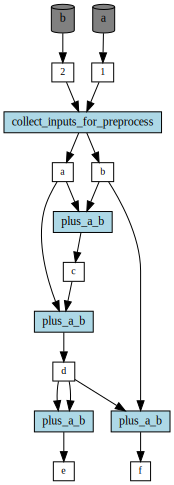

In [7]:
preprocess.pipe.view(summary=False)

In [8]:
preprocess.pipe.e.get()

[REMOVE] result of "plus_a_b"
[REMOVE] result of "plus_a_b"


8

In [10]:
preprocess.pipe.c.get()

3

In [9]:
preprocess.pipe.f.get()

6

# Visualization of the Data Pipeline in an Experiment 

In [ ]:
from experiments.ex3.connect_pipeline import pipe

In [ ]:
pipe.view(summary=False)

## checking dependency 

In [ ]:
pipe.view_dependency('split_data',summary=False)

## viewing data content, size, and type 

In [ ]:
pipe.view(summary=False, option = 'all')

## viewing data size and type only 

In [ ]:
pipe.view(summary=False, option = 'light')

In [ ]:
pipe.view_dependency('split_data',summary=False, option='light')

# Obtain values of a temporary result of the pipeline 

In [ ]:
pipe.test_dataset.get(verbose=True)   

# Example of making modification to the pipeline 

# define new function and connect in the end 

In [ ]:
@pipe._func_
def get_length(tensor_dataset):
    return len(tensor_dataset)

pipe.setup_connection('size = get_length(train_dataset)')

In [ ]:
pipe.view(summary=False)

In [ ]:
pipe.size.get()

# modify a function

In [ ]:
@pipe._rep_func_('build_TensorDataset')
def build_TensorDataset(x_dense, x_sparse, objmean, tscnt, label_0):
    return "Hello New TensorDataset Result!"

In [ ]:
pipe.test_dataset.get()

In [ ]:
pipe.train_dataset.get()

# ProcessBase Example on ex4 

In [ ]:
from experiments.ex4.preprocess.config import PreProcess  
preprocess = PreProcess(save_tmp=True, experiment_name = 'ex4') 

import os 
origin_path = 'data/source'
preprocess.setup_vars(
    chid_file=os.path.join(origin_path, 'sample_chid.txt'), 
    cdtx_file=os.path.join(origin_path, 'sample_zip_if_cca_cdtx0001_hist.csv'), 
    cust_f_file=os.path.join(origin_path, 'sample_zip_if_cca_cust_f.csv'),
    category_cols=['chid', 'bnsfg', 'iterm', 'mcc', 'scity'], 
    sparse_feat=['chid', 'bnsfg', 'iterm', 'mcc', 'scity'], 
    numeric_cols=['bnspt', 'timestamp_0', 'timestamp_1', 'objam'],
    dense_feat=['bnspt', 'timestamp_0', 'timestamp_1', 'objam'],
    cust_category_cols=['chid', 'masts', 'educd', 'trdtp', 'poscd'], 
    cust_numeric_cols=['slam', 'first_mob', 'constant_change', 'sum_l2_ind',
                  'sum_u2_ind', 'constant_l2_ind', 'constant_u4_ind',
                  'growth_rate', 'monotone_down', 'monotone_up', 'data_dt'],
    target_cols=['chid', 'data_dt', 'objam_sum', 'objam_mean', 'trans_count', 'objam_mean_M3'], 
    USE_CHID=True, 
    time_column_data_dt='data_dt', 
    time_column_csmdt='csmdt', 
    result_column_timestamp_1='timestamp_1', 
    result_column_timestamp_0='timestamp_0', 
    result_column_timestamp='timestamp', 
    LEFT='left', 
    INNER='inner', 
    n_sample=50, 
    window_size=120,
    test_size=2
)

In [ ]:
preprocess.config(verbose=True)  

In [ ]:
preprocess.pipe.sparse_dense_setting_generator.get(verbose=True, load_tmp=True) 

In [ ]:
preprocess.pipe.view(summary=False) 

In [ ]:
preprocess.pipe.x_train.get(verbose=True, load_tmp=True)   

In [ ]:
preprocess.pipe.df_cdtx.get(verbose=True, load_tmp=True)   

In [ ]:
preprocess.pipe.df_full_y_sum.get(verbose=True, load_tmp=True)  

In [ ]:
preprocess.pipe.train_dataset.get(verbose=True, load_tmp=True)  

In [ ]:
preprocess.pipe.test_dataset.get(verbose=True, load_tmp=True)  

# Auto-Delete Unused Memory 

--- 

- [X] make the connection inverse. (add children list variable and add during connection). 
- [X] insert processed variable. 
- [X] once processed, mark processed = True. 
- [X] if all children are processed = True, delete _in_memory_results. (do the check and delete after a parent being processed).  
- [X] change is_processed to is_complete and check if still working ? (not working)






In [ ]:
from experiments.ex4.preprocess.config import PreProcess  
preprocess = PreProcess(save_tmp=True, experiment_name = 'ex4') 

import os 
origin_path = 'data/source'
preprocess.setup_vars(
    chid_file=os.path.join(origin_path, 'sample_chid.txt'), 
    cdtx_file=os.path.join(origin_path, 'sample_zip_if_cca_cdtx0001_hist.csv'), 
    cust_f_file=os.path.join(origin_path, 'sample_zip_if_cca_cust_f.csv'),
    category_cols=['chid', 'bnsfg', 'iterm', 'mcc', 'scity'], 
    sparse_feat=['chid', 'bnsfg', 'iterm', 'mcc', 'scity'], 
    numeric_cols=['bnspt', 'timestamp_0', 'timestamp_1', 'objam'],
    dense_feat=['bnspt', 'timestamp_0', 'timestamp_1', 'objam'],
    cust_category_cols=['chid', 'masts', 'educd', 'trdtp', 'poscd'], 
    cust_numeric_cols=['slam', 'first_mob', 'constant_change', 'sum_l2_ind',
                  'sum_u2_ind', 'constant_l2_ind', 'constant_u4_ind',
                  'growth_rate', 'monotone_down', 'monotone_up', 'data_dt'],
    target_cols=['chid', 'data_dt', 'objam_sum', 'objam_mean', 'trans_count', 'objam_mean_M3'], 
    USE_CHID=True, 
    time_column_data_dt='data_dt', 
    time_column_csmdt='csmdt', 
    result_column_timestamp_1='timestamp_1', 
    result_column_timestamp_0='timestamp_0', 
    result_column_timestamp='timestamp', 
    LEFT='left', 
    INNER='inner', 
    n_sample=50, 
    window_size=120,
    test_size=2
)

In [ ]:
preprocess.config(verbose=True)  

In [ ]:
preprocess.pipe.train_dataset.get(verbose=True, 
                                  load_tmp=True, 
                                  handle_wastes=False) 

In [ ]:
preprocess.pipe.test_dataset.get(verbose=True, load_tmp=True, handle_wastes=False)  

In [ ]:
preprocess.pipe.sparse_dense_setting_generator.get(verbose=True, load_tmp=True)  